In [4]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from matplotlib import pyplot as plt

В данной работе вы познакомитесь с простой нейронной сетью для решения задачи распознавания рукописных цифр из набора данных MNIST

![jupyter](https://storage.googleapis.com/tfds-data/visualization/fig/mnist-3.0.1.png)

### Создание нейронной сети

Создаем класс нейронной сети.

Наследуемся от nn.Module

Создаем методы init и forward.

В init инициализируем слои в поля класса (через self.название_слоя) см. пример. Пропишите сверточные слои, линейные слои, дропауты и maxpool

В forward создаем "путь" по которому пройдут входные данные. Функция должна вернуть результат всех преобразований.

#### Задание

1) Допишите в метод init необходимые слои из приложенной схемы

2) Допишите в метод forward "путь" входных данных через все слои и присвойте переменной output полученное значение

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1M5ppV_EvwzG-265VbQb0ZsK6GL2wxMVC/preview" width="640" height="480" allow="autoplay"></iframe>

In [5]:
class CN_Net(nn.Module):
    def __init__(self):
        super(CN_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool2 = nn.MaxPool2d(2, 2)

        
        self._to_linear = None
        self._to_linear = self._calc_linear_input_size((1, 28, 28))

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    

    def _calc_linear_input_size(self, shape):
        x = torch.randn(1, *shape) 
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        return x.reshape(1, -1).size(1)  



    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        
        x = x.reshape(-1, self._to_linear)  

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = self.log_softmax(x)
        return output        

### Обучение и тестирование нейронной сети

Нейронная сеть представляет собой некоторую последовательность слоев, связанных между собой.
Их можно рассматривать как матричные преобразования.

Так как мы не знаем нужные веса нашей сети для решения поставленной задачи, то после каждого шага мы будем сверять полученные значения с целевыми, внося поправки в веса при помощи обратного распространения ошибки.

Создадим функцию для обучения нашей сети. На вход подаем:
- словарь, содержащий гиперпараметры
- модель
- устройство на котором будем считать (в нашем случае это CPU)
- загрузчик данных
- оптимизатор
- количество эпох

### Задание

Допишите нехватающие элементы в функции train

In [7]:
def train(args: dict,
          model: nn.Module,
          device: torch.device,
          train_loader,
          optimizer: torch.optim,
          epoch: int):
    model.train()

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
 
        optimizer.zero_grad()  
        output = model(data)  

        
        loss = F.nll_loss(output, target)  
        loss.backward()  

        optimizer.step()

        
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


Создадим функцию для тестирования нашей сети. На вход подаем:
- модель
- устройство, на котором будем считать
- загрузчик данных
- оптимизатор

### Задание

Допишите нехватающие элементы в функции test

In [8]:
def test(model: nn.Module,
         device,
         test_loader):
    # переведем модель в режим предсказания
    model.eval()

    # создадим переменные для подсчета суммарного значения функции потерь и количества правильных ответов
    test_loss = 0.0
    correct = 0.0

    #  запустим цикл в режиме без расчета градиентов
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # передадим данные в модель
            output = model(data)  # вместо многоточия ваш код

            # просуммируем значения функции потерь на текущем шаге с общей
            # используйте ту же функцию потерь что и в train (чтобы получить значение вызовите метод .item())
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # вместо многоточия ваш код

            # найдем позицию (метку класса) максимального элемента предсказания при помощи argmax
            pred = output.argmax(dim=1, keepdim=True)  # вместо многоточия ваш код

            # подсчитаем количество верных ответов
            correct += pred.eq(target.view_as(pred)).sum().item()

    # подсчитаем среднее значение функции потерь для всего набора данных
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

### Гиперпараметры

Для обучения сети нам потребуется задать параметры от которых мы будем отталкиваться при формировании учебных наборов, шагов оптимизатора и т.д.

In [9]:
args = {'batch_size': 64,
        'test_batch_size': 1000,
        'epochs': 14,
        'lr': 1.0,
        'gamma': 0.7,
        'log_interval': 1000,
        'save_model': False
        }

зададим устройство, на котором будем производить расчеты. Расчеты на GPU не будем рассматривать в рамках нашего курса. Если запускаете на collab то поменяйте параметр cpu на gpu

In [10]:
device = torch.device("cpu")

создадим два словаря с ключами 'batch_size'
значения для них возьмем из args по ключам batch_size и test_batch_size соответственно

In [11]:
train_kwargs = {'batch_size': args['batch_size']}
test_kwargs  = {'batch_size': args['test_batch_size']}

создадим пайплайн предобработки данных из набора данных

Поместим в него преобразование в тензоры (для работы torch) и нормализацию данных

In [12]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

скачаем учебный и тестовый наборы данных при помощи datasets.MNIST

для учебного набора укажите:
- папку сохранения
- флаг скачивания учебного набора
- параметр transform=transform, который преобразует наши данные так, как мы задали выше

### Задание

Заполните аргументы в ячейке ниже для скачивания наборов данных

In [15]:
dataset1 = datasets.MNIST("../MNIST/train", train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
dataset2 = datasets.MNIST("../MNIST/test", train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

100.0%
100.0%
100.0%
100.0%


Создадим загрузчики данных при помощи DataLoader из torch

In [16]:
train_loader = DataLoader(dataset1, **train_kwargs)
test_loader  = DataLoader(dataset2, **test_kwargs)

### Задание

инициализируйте модель:

In [19]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = CN_Net().to(device)

инициализируем оптимизатор и планировщик

Оптимизатор отвечает за стратегию нахождения минимума

Планировщик позволяет уменьшать шаг оптимизатора на заданную гамму

In [20]:
optimizer = optim.Adadelta(model.parameters(), lr=args['lr'])
scheduler = StepLR(optimizer, step_size=1, gamma=args['gamma'])

Создадим цикл, в котором будет количество повторений равное количество эпох.
Получим из test значение лосс-функции на тестовой выборке.

Внутри тела цикла вызовем поочередно функции обучения и тестирования с требуемыми аргументами.

Насладимся результатами.

In [21]:
losses = []
for epoch in range(1, args['epochs'] + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    loss = test(model, device, test_loader)
    losses.append(loss)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306472

Test set: Average loss: 0.0520, Accuracy: 9835.0/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.027360

Test set: Average loss: 0.0321, Accuracy: 9884.0/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.037794

Test set: Average loss: 0.0353, Accuracy: 9889.0/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.051919

Test set: Average loss: 0.0361, Accuracy: 9889.0/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.013782

Test set: Average loss: 0.0336, Accuracy: 9910.0/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.001050

Test set: Average loss: 0.0398, Accuracy: 9911.0/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000640

Test set: Average loss: 0.0478, Accuracy: 9896.0/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.001339

Test set: Average loss: 0.0420, Accuracy: 9915.0/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.006240

Test set: Average loss: 0.0547, Accuracy: 9893.0/10000 (99%)

Train Epoch: 10 [0/60000 (0%

Отрисуем график функции потерь на тестовом наборе в зависимости от эпохи

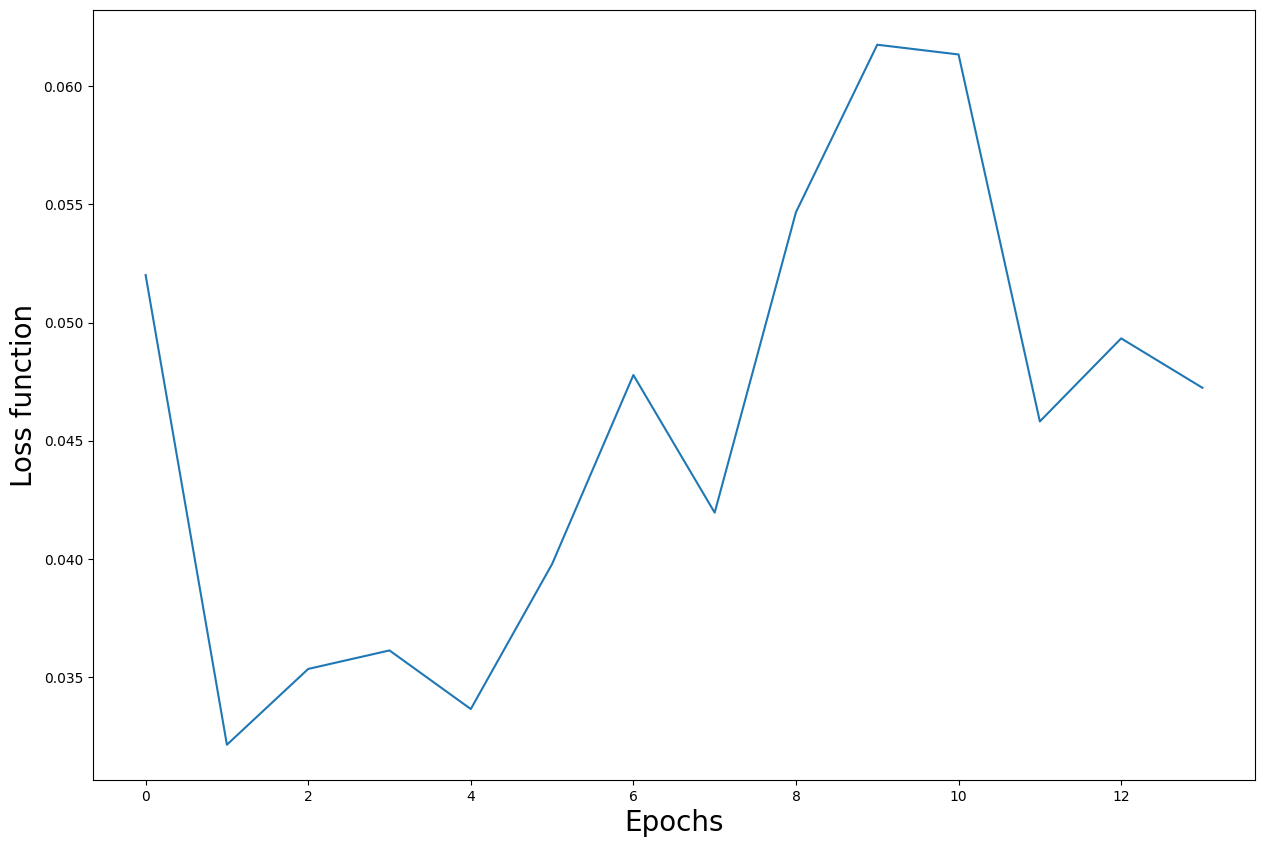

In [22]:
plt.figure(figsize=(15, 10))
plt.plot(losses)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss function', size=20)
plt.show()